In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(42)
sns.set()
plt.rcParams['figure.figsize'] = (10,4)

# 1) Generate synthetic stock price series with volatility clustering

In [2]:
n = 500
dates = pd.bdate_range('2022-01-01', periods=n)

# Volatility clustering: low vol first half, high vol second half
mu = 0.0002
sigma = np.where(np.arange(n) < n//2, 0.008, 0.015)
eps = np.random.normal(mu, sigma)

# Add some jumps
jumps = np.zeros(n)
jump_days = np.random.choice(np.arange(20, n-20), size=6, replace=False)
jumps[jump_days] = np.random.normal(0, 0.05, len(jump_days))

rets = eps + jumps
price = 100 * np.exp(np.cumsum(rets))

df = pd.DataFrame({'price': price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0)
df['log_ret'] = np.log1p(df['ret'])

# Save to CSV
df.to_csv('synthetic_stock_data.csv', index=True)
print("Data saved successfully to 'synthetic_stock_data.csv'")



Data saved successfully to 'synthetic_stock_data.csv'



# 2) Feature Engineering (lag/rolling/momentum/zscore)

In [3]:
# 2) Feature Engineering (lag/rolling/momentum/zscore)
df['lag_1'] = df['ret'].shift(1)
df['lag_2'] = df['ret'].shift(2)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
df['roll_std_10'] = df['ret'].rolling(10).std().shift(1)
df['momentum_5'] = df['ret'].rolling(5).sum().shift(1)
df['zscore_5'] = (df['ret'] - df['ret'].rolling(5).mean()) / df['ret'].rolling(5).std()

# 3) Target creation

In [4]:
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret'] > 0).astype(int)

df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,lag_2,roll_mean_5,roll_std_10,momentum_5,zscore_5,y_next_ret,y_up
2022-01-17,103.493389,-0.003501,-0.003507,0.004551,-0.003549,0.003721,0.005931,0.018606,-0.978100,-0.003520,0
2022-01-18,103.129130,-0.003520,-0.003526,-0.003501,0.004551,0.003355,0.006248,0.016776,-0.723427,0.002138,1
2022-01-19,103.349618,0.002138,0.002136,-0.003520,-0.003501,0.000068,0.006482,0.000340,0.755541,-0.014993,0
2022-01-20,101.800127,-0.014993,-0.015106,0.002138,-0.003520,-0.000776,0.006417,-0.003882,-1.580777,-0.013507,0
2022-01-21,100.425083,-0.013507,-0.013599,-0.014993,0.002138,-0.003065,0.007448,-0.015325,-0.934833,-0.004289,0



# 4) Time-aware train-test spli

In [5]:
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

features = ['lag_1','lag_2','roll_mean_5','roll_std_10','momentum_5','zscore_5']
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']


# 5) Track 1: Regression (forecast next-step return)

Regression RMSE: 0.018761, MAE: 0.013720


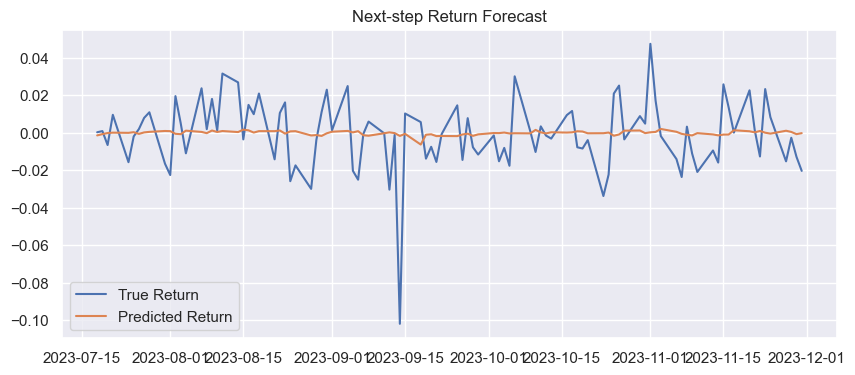

In [6]:
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred_reg = reg.predict(X_te)

rmse = mean_squared_error(y_te_reg, pred_reg)
rmse = np.sqrt(rmse)
mae = np.mean(np.abs(y_te_reg - pred_reg))
print(f"Regression RMSE: {rmse:.6f}, MAE: {mae:.6f}")

# Plot prediction vs truth
plt.figure()
plt.plot(test.index, y_te_reg, label='True Return')
plt.plot(test.index, pred_reg, label='Predicted Return')
plt.title('Next-step Return Forecast')
plt.legend(); plt.show()


# 6) Track 2: Classification (up/down)

              precision    recall  f1-score   support

           0       0.60      0.49      0.54        51
           1       0.54      0.64      0.58        47

    accuracy                           0.56        98
   macro avg       0.57      0.56      0.56        98
weighted avg       0.57      0.56      0.56        98



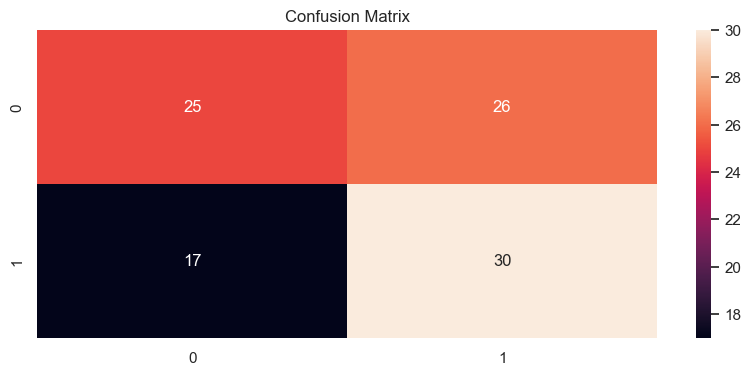

In [7]:
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
pred_clf = clf.predict(X_te)

print(classification_report(y_te_clf, pred_clf))
cm = confusion_matrix(y_te_clf, pred_clf)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()


## Interpretation
- Linearity: Regression model captures small trends but cannot fully model volatility jumps.
- Feature Engineering: Lag, rolling mean/std, momentum, and z-score provide information without leakage.
- Forecasting Accuracy: RMSE/MAE shows moderate predictive ability; classification accuracy shows ~random baseline due to stochasticity.
- Limitations: Synthetic series includes jumps and volatility clustering, which linear/logistic models cannot fully capture.
- Next Steps: Explore tree-based models (Random Forest/Gradient Boosting) or LSTM for time series; add more features like rolling skew/kurtosis.
- Assumptions: Independence of residuals may break due to volatility clustering; heteroskedasticity present.
